In [1]:
# -*- coding: utf-8 -*-

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from configuration import Config
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sp
from datetime import datetime, timedelta
# from sklearn.preprocessing import MinMaxScaler
import joblib
from gconv import MGConv, calculate_scaled_laplacian
from base_model import UNetSTMGCN2
from load_data import load_adj_npz, generate3feat
# from base_model import ImprvSTMGCN
print(tf.__version__)
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2.1.0


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
scaler = joblib.load('scaler.pkl')
config = Config(os.path.join(os.getcwd(), "config_local_3Feat.yaml"))

---------------------------------- APP CONFIG ----------------------------------
data: 
  data_path: data/Data_2019-6-11_to_2019-12-31.csv
  nbhd_adj_path: graph/EucAdjMatrix_align.npz
  simi_adj_path: graph/Simi_SparseMatrix_align.npz
  cont_adj_path: graph/RoadMaps_AdjMatrix_align_scaled.npz
  time_length: 16
  feature_dims: 3
train: 
  batch_size: 4
  epoch: 50
  normalize_type: vertex
valid: 
  batch_size: 2
  coefficient: 7
inference: 
  data_path: data/Data_2019-6-11_to_2019-12-31.csv
  model: BestModel/MFeat_last1y_16_T3-h32-G1diff_UNetSTMGCN2_mse_opt-adam_bs2_2019_10to2019_12.h5
  batch_size: 1
  start: 10/1/2019
  end: 12/31/2019
graph: 
  num_vertices: 11520
model: 
  loss: mse
  attention: False
  en_ksize: [3, 3, 3]
  de_ksize: [3, 3, 3]
  num_layers: 3
  hidden_dims: 32
  keep_drop: 0.1
  max_diffusion_step: 1
  input_dims: 11520
  output_dims: 11520
  regularizer_scale: 0.003
optimizer: 
  method: adam
  learning_rate: 1e-05
-----------------------------------------------

In [3]:
def load_data_3feat(path_data, time_steps, num_vertices, feature_dims, nrows=None, skiprows=0, normalize_type='vertex'):
    # load dataset
    
    # dataset.shape = [time_length, num_vertices, feature_dims]
    if path_data.endswith('.csv'):
        dataset = pd.read_csv(path_data, index_col=0, nrows=nrows, skiprows=skiprows)
        dataset = dataset.values.astype('float32')
    else:
        dataset = np.load(path_data, allow_pickle=True)['arr_0']
        dataset = dataset[:nrows,:,:feature_dims]
        dataset = dataset.astype('float32')
    
    # normalize features
    # scaled = scaler.fit_transform(dataset)
    scaled = scaler.transform(dataset)
    
    print('dataset.shape = {} -------------------------------------------------------------------'.format(dataset.shape))
    
    X_test,  y_test  = generate3feat(scaled,  time_steps, num_vertices, feature_dims)
    return X_test,  y_test

In [4]:
# Set GPU as available physical device
GPU_num = 0
my_devices = tf.config.experimental.list_physical_devices(device_type='GPU')[GPU_num]
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='GPU')

In [ ]:
## Data Loading 

nbhd_adj, simi_adj, cont_adj = load_adj_npz(npz_nbhd_path=config.data.nbhd_adj_path,
                                            npz_simi_path=config.data.simi_adj_path,
                                            npz_cont_path=config.data.cont_adj_path)
X_test, y_test = load_data_3feat(config.inference.data_path,
                                 time_steps=config.data.time_length,
                                 num_vertices=config.graph.num_vertices,
                                 feature_dims=config.data.feature_dims,
                                 normalize_type=config.train.normalize_type,  
                                 skiprows=0)
X_test.shape, y_test.shape

In [ ]:
model = UNetSTMGCN2(batch_size=config.inference.batch_size, 
                    num_vertices=config.graph.num_vertices, 
                    time_length=config.data.time_length, 
                    feature_dims=config.data.feature_dims, 
                    hidden_dims=config.model.hidden_dims,
                    en_ksize=config.model.en_ksize, 
                    de_ksize=config.model.de_ksize,
                    nbhd_adj=nbhd_adj, 
                    simi_adj=simi_adj, 
                    cont_adj=cont_adj, 
                    with_attention=config.model.attention,
                    regularizer_scale=config.model.regularizer_scale)

_ = model(tf.convert_to_tensor(X_test[:config.inference.batch_size]))
model.load_weights(config.inference.model)

In [7]:
X_test_split = np.array_split(X_test, X_test.shape[0]/config.inference.batch_size)

y_pred = []
for split_tmp in tqdm(X_test_split):
    y_pred.append(model(tf.convert_to_tensor(split_tmp)))
    
y_pred = np.concatenate(y_pred, axis=0)

100%|██████████| 8832/8832 [07:52<00:00, 18.69it/s]


In [8]:
y_pred.shape, y_test.shape

((8832, 11520), (8832, 11520))

In [9]:
# np.save('MFeat_lastly_16_T6-32-G1diff_UNetSTMGCN2_mse_y_pred.npy', y_pred)
# np.save('MFeat_last1y_16_T6-32-G1diff_UNetSTMGCN2_mse_y_test.npy', y_test)

unscaled_y_pred = scaler.inverse_transform(y_pred)
unscaled_y_test = scaler.inverse_transform(y_test)

# np.save('MFeat_last1y_16_T6-32-G1diff_UNetSTMGCN2_mse_unscaled_y_pred.npy', unscaled_y_pred)
# np.save('MFeat_last1y_16_T6-32-G1diff_UNetSTMGCN2_mse_unscaled_y_test.npy', unscaled_y_test)

# Performance

In [10]:
def performance(unscaled_y_test, unscaled_y_pred, city, coef=False):
    unscaled_y_test_list = np.array_split(unscaled_y_test[:,city], int(unscaled_y_pred.shape[0]/(4*24)))
    unscaled_y_pred_list = np.array_split(unscaled_y_pred[:,city], int(unscaled_y_pred.shape[0]/(4*24)))
    
    ratio = 1
    estimate_list = []
    accuracy_list = []
    rmse_list = []
    y_pred_list = [1]
    y_test_list = [1]
    for y_test, y_pred in zip(unscaled_y_test_list, unscaled_y_pred_list):
        ## Estimate
        if y_test.sum() > y_pred.sum()/ratio:
            estimate_list.append(0)
        else:
            estimate_list.append(1)

        ## Accuracy
        # accuracy_tmp =  1 - abs(y_test.sum()*ratio - y_pred.sum())/ (y_test.sum()*ratio)
        accuracy_tmp =  1 - abs(y_test.sum() - y_pred.sum()/ratio)/ y_test.sum()
        accuracy_list.append(accuracy_tmp)

        ## RMSE 
        rmse_tmp = mean_squared_error(y_test, y_pred/ratio)
        rmse_list.append(rmse_tmp)
        
        if coef:
            ## Ratio
            # ratio_list.append(y_pred.sum()/y_test.sum())
            y_pred_list.append(y_pred.sum())
            y_test_list.append(y_test.sum())
            ratio = np.sum(y_pred_list[-coef:])/ np.sum(y_test_list[-coef:])
        
    print ('Average accuracy: {:.6f}'.format(np.mean(accuracy_list)))
    print ('Min accuracy: {:.6f}'.format(np.min(accuracy_list)))
    print ("MSE: {:.6f}, \nRMSE: {:.6f}, \nNaive: {:.6f}, \nMean: {:.6f}".format(mean_squared_error(unscaled_y_test[:,city], 
                                                                                                    unscaled_y_pred[:,city]),
                                                                                 np.sqrt(mean_squared_error(unscaled_y_test[:,city], 
                                                                                                            unscaled_y_pred[:,city])), 
                                                                                 np.sqrt(mean_squared_error(unscaled_y_test[1:,city], 
                                                                                                            unscaled_y_test[:-1,city])), 
                                                                                 np.sqrt(mean_squared_error(unscaled_y_test[:,city], 
                                                                                                            np.full_like(unscaled_y_test[:,city],
                                                                                                                         unscaled_y_test[:,city].mean(axis=0))))))
    return estimate_list, accuracy_list, rmse_list


# def AccPlot(estimate_list, accuracy_list, rmse_list, naive_list, mean_list, time):
def MetricsPlot(estimate_list, accuracy_list, rmse_list, time, save=False):
    plt.figure(figsize=(20,7))
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    plt.ylim(0,1)
    plt.grid(color = '#9999CC', linestyle=':', linewidth=1)
    plt.plot(time, accuracy_list, label='Accuracy', color='#598987', markersize=5)
    plt.plot(time, [0.85 for n in range(len(accuracy_list))], '--', label='Baseline', color='#FF6670')
    plt.plot(time[np.where(np.array(estimate_list)==1)], 
             np.array(accuracy_list)[np.where(np.array(estimate_list)==1)], '^', label='Overestimate', color='#7d3f98', markersize=5)
    plt.plot(time[np.where(np.array(estimate_list)==0)], 
             np.array(accuracy_list)[np.where(np.array(estimate_list)==0)], 'o', label='Underestimate', color='#E07B42', markersize=5)
    plt.plot(time, rmse_list, label='RMSE', color='#D9B300')
    # plt.plot(time, naive_list, label='Naive', color='#26C6DA')
    # plt.plot(time, mean_list, label='Mean', color='#1A237E')
    plt.legend(loc='center right')
    if bool(save):
        plt.savefig('{}.jpg'.format(save), dpi=300)
    plt.show()

In [11]:
UrbanList = ['台南市', '高雄市', '桃園市','台中市', '台北市','新北市']
geoHash = pd.read_csv('data/geoHash2City.csv', index_col=0)
GridSorting = pd.read_csv('data/GridSorting.csv', header=None)
geoHash = geoHash.reindex(GridSorting[0].values)
time = pd.date_range(start=config.inference.start , end = config.inference.end, freq='1D')

# All Grids

Average accuracy: 0.972350
Min accuracy: 0.866442
MSE: 0.121321, 
RMSE: 0.348312, 
Naive: 0.472201, 
Mean: 0.474512


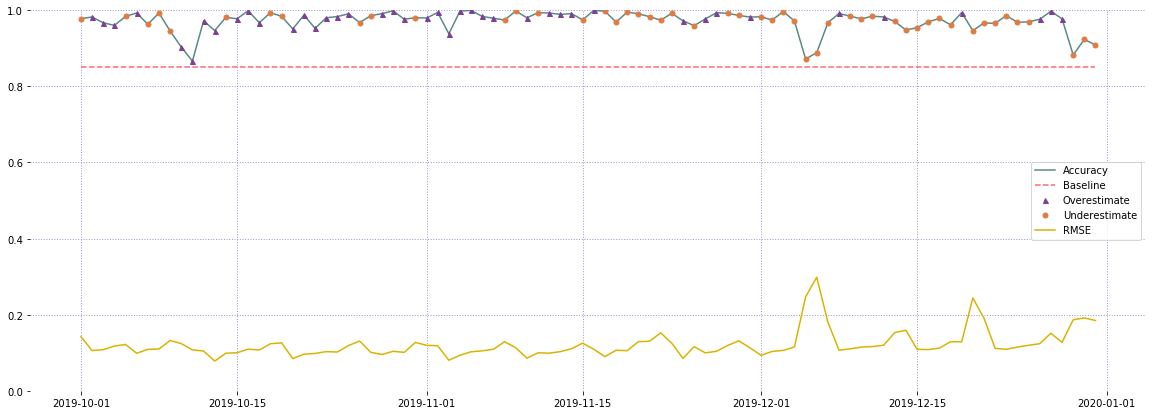

In [12]:
city = range(unscaled_y_test.shape[1])
estimate_list, accuracy_list, rmse_list = performance(unscaled_y_test, unscaled_y_pred, city)
MetricsPlot(estimate_list, accuracy_list, rmse_list, time)

Average accuracy: 0.972719
Min accuracy: 0.867679
MSE: 0.121321, 
RMSE: 0.348312, 
Naive: 0.472201, 
Mean: 0.474512


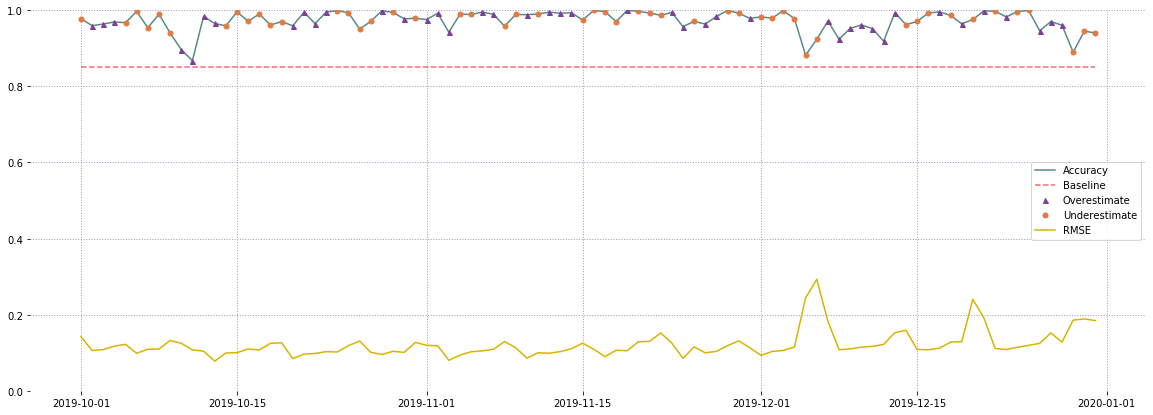

In [13]:
## COVID19 coefficient
estimate_list, accuracy_list, rmse_list = performance(unscaled_y_test, unscaled_y_pred, city, config.valid.coefficient)
MetricsPlot(estimate_list, accuracy_list, rmse_list, time)

# 六都

Average accuracy: 0.972064
Min accuracy: 0.860916
MSE: 0.224892, 
RMSE: 0.474228, 
Naive: 0.642747, 
Mean: 0.651172


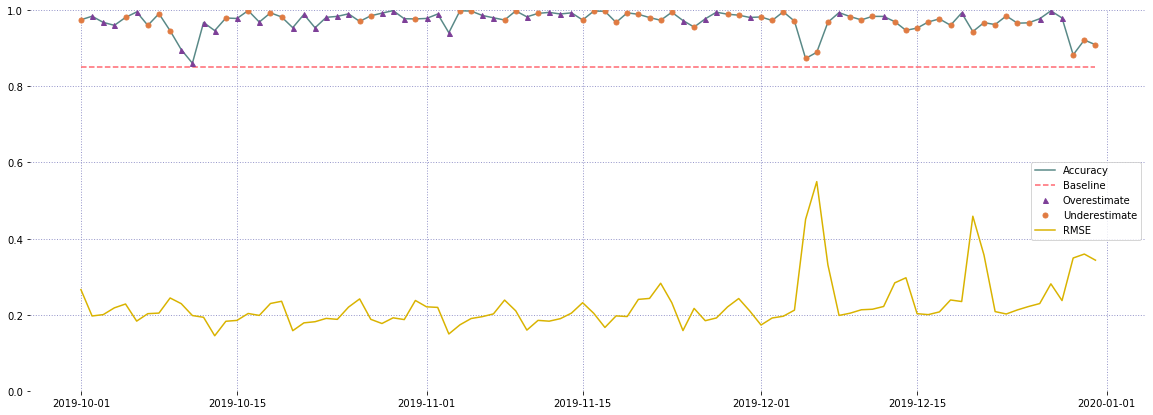

In [14]:
city = geoHash.City.apply(lambda x:x in UrbanList)
# estimate_list, accuracy_list, rmse_list, naive_list, mean_list = performance(unscaled_y_test, unscaled_y_pred, city)
# AccPlot(estimate_list, accuracy_list, rmse_list, naive_list, mean_list, time)

estimate_list, accuracy_list, rmse_list = performance(unscaled_y_test, unscaled_y_pred, city)
MetricsPlot(estimate_list, accuracy_list, rmse_list, time)

Average accuracy: 0.972329
Min accuracy: 0.861482
MSE: 0.224892, 
RMSE: 0.474228, 
Naive: 0.642747, 
Mean: 0.651172


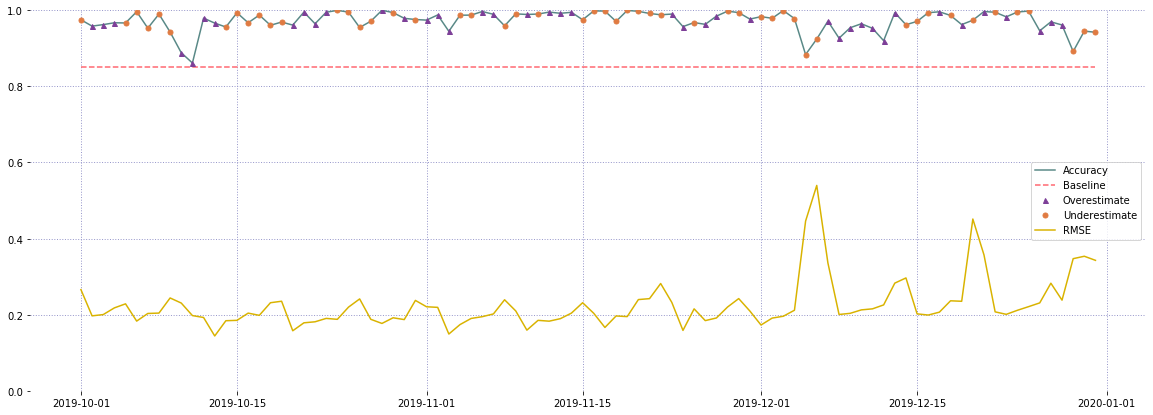

In [15]:
## COVID19 coefficient
estimate_list, accuracy_list, rmse_list = performance(unscaled_y_test, unscaled_y_pred, city, config.valid.coefficient)
MetricsPlot(estimate_list, accuracy_list, rmse_list, time)

# 非六都

Average accuracy: 0.961176
Min accuracy: 0.850909
MSE: 0.012325, 
RMSE: 0.111018, 
Naive: 0.151209, 
Mean: 0.126028


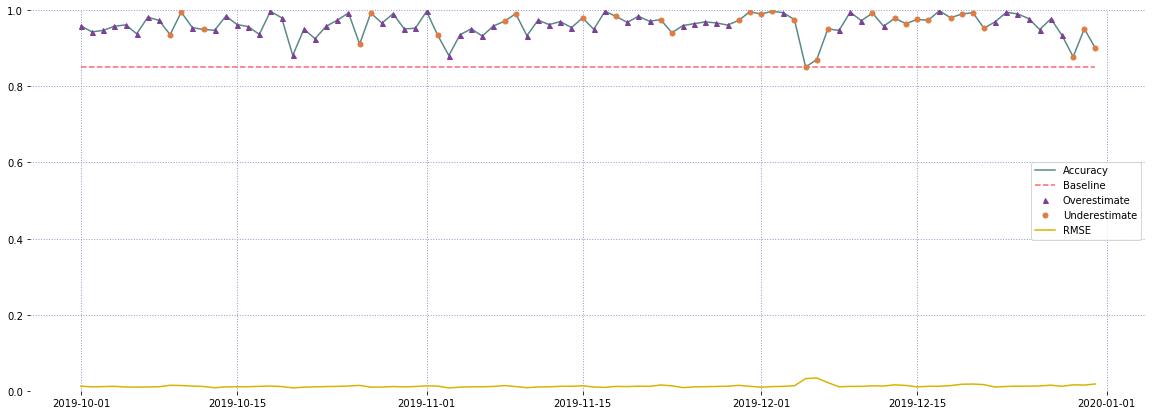

In [16]:
city = geoHash.City.apply(lambda x:x not in UrbanList)
# estimate_list, accuracy_list, rmse_list, naive_list, mean_list = performance(unscaled_y_test, unscaled_y_pred, city)
# AccPlot(estimate_list, accuracy_list, rmse_list, naive_list, mean_list, time)

estimate_list, accuracy_list, rmse_list = performance(unscaled_y_test, unscaled_y_pred, city)
MetricsPlot(estimate_list, accuracy_list, rmse_list, time)

Average accuracy: 0.962141
Min accuracy: 0.852838
MSE: 0.012325, 
RMSE: 0.111018, 
Naive: 0.151209, 
Mean: 0.126028


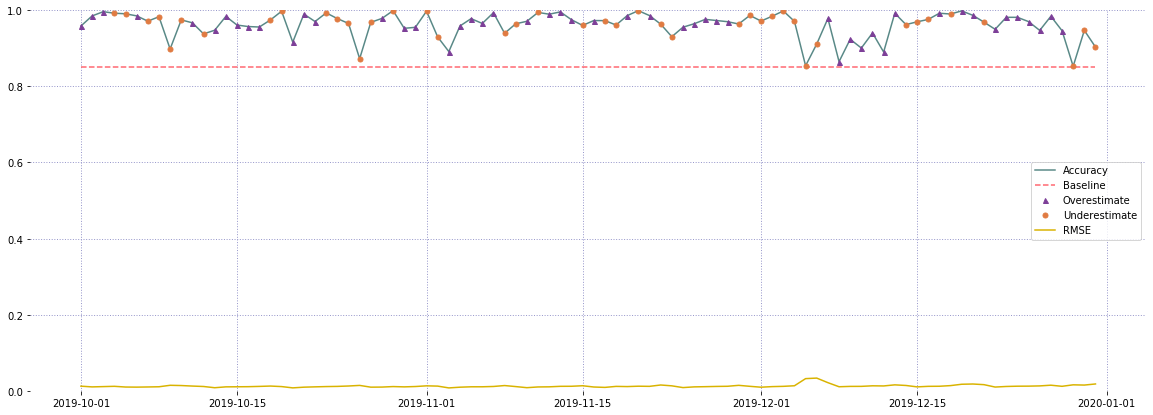

In [17]:
## COVID19 coefficient
estimate_list, accuracy_list, rmse_list = performance(unscaled_y_test, unscaled_y_pred, city, config.valid.coefficient)
MetricsPlot(estimate_list, accuracy_list, rmse_list, time)

# Plotting

In [18]:
end = datetime.strptime(config.inference.end, "%m/%d/%Y") + timedelta(1)
time2 = pd.date_range(start=config.inference.start , end = datetime.strftime(end, "%m/%d/%Y"), freq='15T')

In [19]:
def plotting(y_pred, y_test, index, start, time):
    plt.figure(figsize=(20,3))
    # plt.xlabel("Date Time") 
    plt.ylabel("Customers' demands")
    
    index = np.where(geoHash.index == index)[0][0]
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    n = 500
    plt.grid(color = '#9999CC', linestyle=':', linewidth=1)
    plt.plot(time[start:start+n], y_pred[start:start+n,index], label='Forecast', color='#FF0000')
    plt.plot(time[start:start+n], y_test[start:start+n,index], label='Reality', color='#66B3FF')
    # plt.plot(time[start:start+500], y_pred[start:start+500,index], label='Forecast')
    # plt.plot(time[start:start+500], y_test[start:start+500,index], label='Reality')
    plt.legend(loc='upper right')
    plt.show()

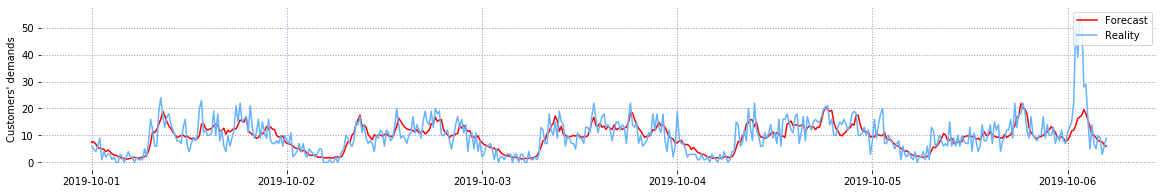

In [20]:
plotting(unscaled_y_pred, unscaled_y_test, index='wsqqmy', start=0, time=time2)

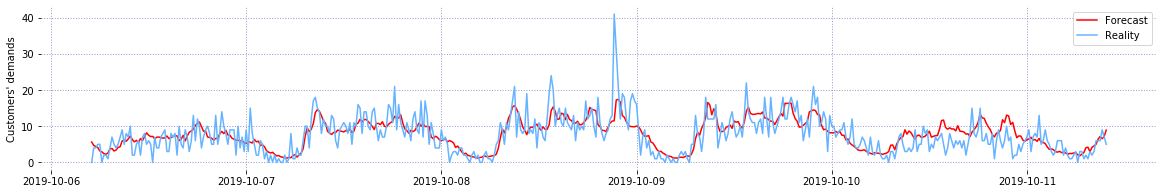

In [21]:
plotting(unscaled_y_pred, unscaled_y_test, index='wsqqmy' , start=500, time=time2)

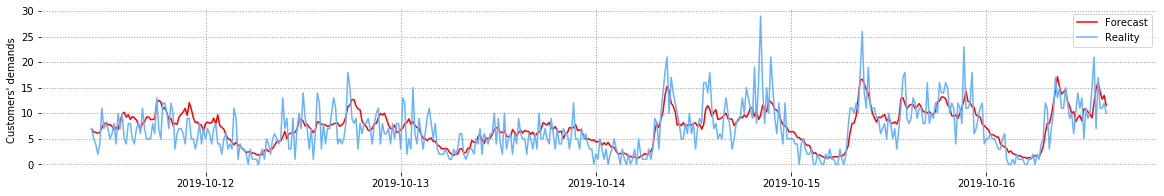

In [22]:
plotting(unscaled_y_pred, unscaled_y_test, index='wsqqmy', start=1000, time=time2)

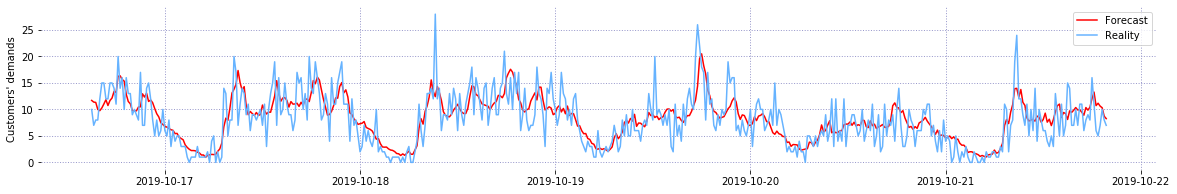

In [23]:
plotting(unscaled_y_pred, unscaled_y_test, index='wsqqmy', start=1500, time=time2)

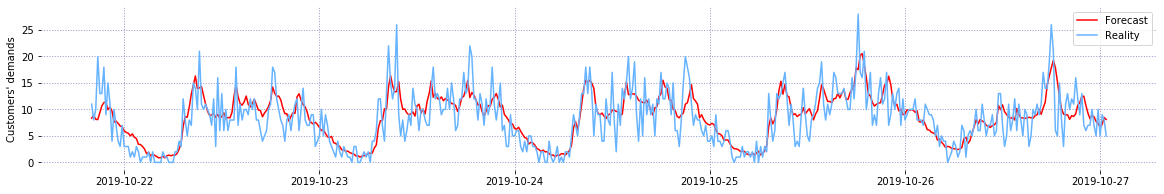

In [24]:
plotting(unscaled_y_pred, unscaled_y_test, index='wsqqmy', start=2000, time=time2)

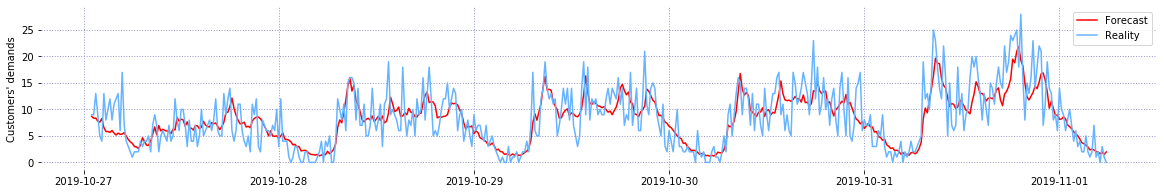

In [25]:
plotting(unscaled_y_pred, unscaled_y_test, index='wsqqmy', start=2500, time=time2)